## Step 1: Loading the Data
We will load the `train`, `test`, and `misconception_mapping` datasets to begin our analysis. These datasets contain the question texts, answers, and misconceptions related to each incorrect answer (distractor).


In [2]:
import os

# List all files in the Kaggle input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/eedi-mining-misconceptions-in-mathematics/sample_submission.csv
/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv
/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv
/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv


## Step 2: Data Preprocessing
We'll check for missing values in the misconception columns and clean the data accordingly.


In [3]:
# Import necessary libraries
import pandas as pd

# Load the CSV files with the correct file paths
train = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/train.csv')
test = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/test.csv')
misconception_mapping = pd.read_csv('/kaggle/input/eedi-mining-misconceptions-in-mathematics/misconception_mapping.csv')

# Display the first few rows of each dataframe to verify the data is loaded correctly
print("Train Data Head:")
print(train.head())

print("\nTest Data Head:")
print(test.head())

print("\nMisconception Mapping Head:")
print(misconception_mapping.head())


Train Data Head:
   QuestionId  ConstructId                                      ConstructName  \
0           0          856  Use the order of operations to carry out calcu...   
1           1         1612  Simplify an algebraic fraction by factorising ...   
2           2         2774            Calculate the range from a list of data   
3           3         2377  Recall and use the intersecting diagonals prop...   
4           4         3387  Substitute positive integer values into formul...   

   SubjectId                                        SubjectName CorrectAnswer  \
0         33                                             BIDMAS             A   
1       1077                    Simplifying Algebraic Fractions             D   
2        339  Range and Interquartile Range from a List of Data             B   
3         88                       Properties of Quadrilaterals             C   
4         67                          Substitution into Formula             A   

         

Checking Missing Values.

In [4]:
# Check for missing values in the train dataset
missing_values = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].isnull().sum()

print("Missing values per Misconception column:")
print(missing_values)


Missing values per Misconception column:
MisconceptionAId    734
MisconceptionBId    751
MisconceptionCId    789
MisconceptionDId    832
dtype: int64


Task: Fill the Missing Values
Here’s the code to handle the missing values by filling them with -1:

In [5]:
# Fill missing misconception values with -1 (indicating no misconception)
train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']] = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].fillna(-1)

# Verify that there are no more missing values
missing_values_after = train[['MisconceptionAId', 'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId']].isnull().sum()

print("Missing values after filling:")
print(missing_values_after)


Missing values after filling:
MisconceptionAId    0
MisconceptionBId    0
MisconceptionCId    0
MisconceptionDId    0
dtype: int64


# **Step 3: Exploratory Data Analysis (EDA)**
Before building any models, it's crucial to understand the data better. Let's perform some exploratory data analysis.

* 3.1 Understand the Misconception Distribution
* 3.1.1 Combine Misconception Columns

First, we'll combine all misconception IDs into a single Series for analysis.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all misconception IDs into one series
misconceptions = pd.concat([
    train['MisconceptionAId'],
    train['MisconceptionBId'],
    train['MisconceptionCId'],
    train['MisconceptionDId']
], ignore_index=True)

# Exclude the -1 values (no misconception)
misconceptions = misconceptions[misconceptions != -1]

print(f"Total misconceptions (excluding -1): {len(misconceptions)}")


Total misconceptions (excluding -1): 4370


3.1.2 Visualize Misconception Frequency

Let's visualize the frequency of each misconception.

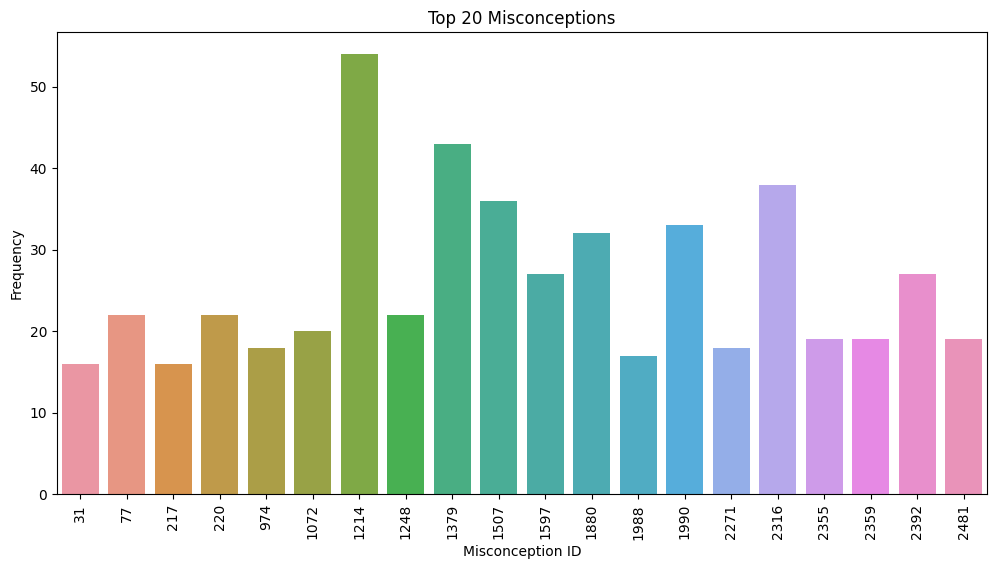

In [7]:
# Count the occurrences of each misconception ID
misconception_counts = misconceptions.value_counts()

# Plot the top 20 most common misconceptions
plt.figure(figsize=(12,6))
sns.barplot(
    x=misconception_counts.head(20).index.astype(int),
    y=misconception_counts.head(20).values
)
plt.title('Top 20 Misconceptions')
plt.xlabel('Misconception ID')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


3.1.3 Analyze Misconception Names

Map the Misconception IDs to their names.



In [8]:
# Merge misconception_counts with misconception_mapping
misconception_counts_df = misconception_counts.reset_index()
misconception_counts_df.columns = ['MisconceptionId', 'Count']
misconception_counts_df = misconception_counts_df.merge(
    misconception_mapping, on='MisconceptionId', how='left'
)

# Display top misconceptions with names
print(misconception_counts_df.head(10))


   MisconceptionId  Count                                  MisconceptionName
0           1214.0     54  When solving an equation, uses the same operat...
1           1379.0     43                          Rounds down instead of up
2           2316.0     38  Mixes up squaring and multiplying by 2 or doub...
3           1507.0     36  Carries out operations from left to right rega...
4           1990.0     33                Fails to reflect across mirror line
5           1880.0     32        Mixes up greater than and less than symbols
6           1597.0     27  Believes multiplying two negatives gives a neg...
7           2392.0     27  Rounds to the wrong degree of accuracy (rounds...
8           1248.0     22  Rounds to the wrong degree of accuracy (rounds...
9            220.0     22  Only multiplies the first term in the expansio...


3.2 Analyze Question and Answer Lengths
Understanding the length of questions and answers can provide insights.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


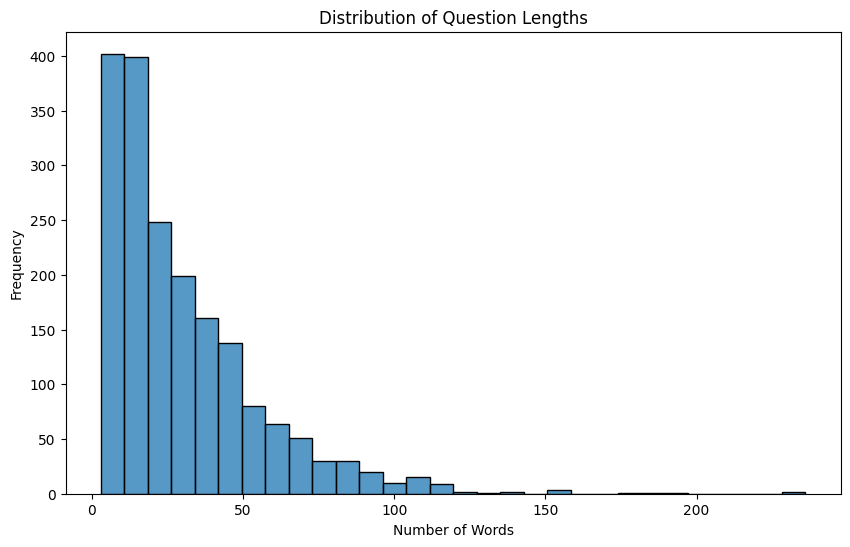

In [9]:
# Add columns for text lengths
train['QuestionLength'] = train['QuestionText'].apply(lambda x: len(str(x).split()))
train['AnswerALength'] = train['AnswerAText'].apply(lambda x: len(str(x).split()))
train['AnswerBLength'] = train['AnswerBText'].apply(lambda x: len(str(x).split()))
train['AnswerCLength'] = train['AnswerCText'].apply(lambda x: len(str(x).split()))
train['AnswerDLength'] = train['AnswerDText'].apply(lambda x: len(str(x).split()))

# Plot distribution of question lengths
plt.figure(figsize=(10,6))
sns.histplot(train['QuestionLength'], bins=30)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [10]:
print("Missing values in 'QuestionText':", train['QuestionText'].isnull().sum())
print("Missing values in 'AnswerAText':", train['AnswerAText'].isnull().sum())
print("Missing values in 'AnswerBText':", train['AnswerBText'].isnull().sum())
print("Missing values in 'AnswerCText':", train['AnswerCText'].isnull().sum())
print("Missing values in 'AnswerDText':", train['AnswerDText'].isnull().sum())


Missing values in 'QuestionText': 0
Missing values in 'AnswerAText': 0
Missing values in 'AnswerBText': 0
Missing values in 'AnswerCText': 0
Missing values in 'AnswerDText': 0


In [12]:
# Fill missing values with empty strings
text_columns = ['QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']
train[text_columns] = train[text_columns].fillna('')


In [14]:
# Add columns for text lengths
train['QuestionLength'] = train['QuestionText'].apply(lambda x: len(str(x).split()))
train['AnswerALength'] = train['AnswerAText'].apply(lambda x: len(str(x).split()))
train['AnswerBLength'] = train['AnswerBText'].apply(lambda x: len(str(x).split()))
train['AnswerCLength'] = train['AnswerCText'].apply(lambda x: len(str(x).split()))
train['AnswerDLength'] = train['AnswerDText'].apply(lambda x: len(str(x).split()))


In [15]:
# Convert all text columns to strings
for col in text_columns:
    train[col] = train[col].astype(str)


In [16]:
def clean_text_encoding(text):
    try:
        return text.encode('utf-8').decode('utf-8')
    except:
        return ''

for col in text_columns:
    train[col] = train[col].apply(clean_text_encoding)


In [17]:
print(train.columns)


Index(['QuestionId', 'ConstructId', 'ConstructName', 'SubjectId',
       'SubjectName', 'CorrectAnswer', 'QuestionText', 'AnswerAText',
       'AnswerBText', 'AnswerCText', 'AnswerDText', 'MisconceptionAId',
       'MisconceptionBId', 'MisconceptionCId', 'MisconceptionDId',
       'QuestionLength', 'AnswerALength', 'AnswerBLength', 'AnswerCLength',
       'AnswerDLength'],
      dtype='object')


In [18]:
# Define a function with exception handling
def count_words(text):
    try:
        return len(str(text).split())
    except Exception as e:
        print(f"Error processing text: {text}\nException: {e}")
        return 0

# Apply the function
train['QuestionLength'] = train['QuestionText'].apply(count_words)
train['AnswerALength'] = train['AnswerAText'].apply(count_words)
train['AnswerBLength'] = train['AnswerBText'].apply(count_words)
train['AnswerCLength'] = train['AnswerCText'].apply(count_words)
train['AnswerDLength'] = train['AnswerDText'].apply(count_words)


Missing values in 'QuestionText': 0
Missing values in 'AnswerAText': 0
Missing values in 'AnswerBText': 0
Missing values in 'AnswerCText': 0
Missing values in 'AnswerDText': 0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


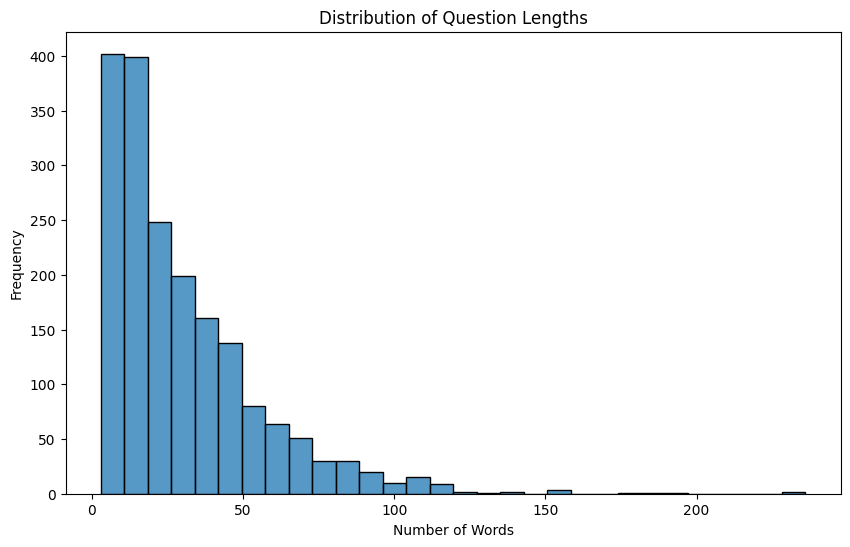

In [19]:
# Step 1: Check for missing values
text_columns = ['QuestionText', 'AnswerAText', 'AnswerBText', 'AnswerCText', 'AnswerDText']
for col in text_columns:
    missing = train[col].isnull().sum()
    print(f"Missing values in '{col}': {missing}")

# Step 2: Fill missing values with empty strings
train[text_columns] = train[text_columns].fillna('')

# Step 3: Ensure all text columns are strings
for col in text_columns:
    train[col] = train[col].astype(str)

# Step 4: Add columns for text lengths
train['QuestionLength'] = train['QuestionText'].apply(lambda x: len(x.split()))
train['AnswerALength'] = train['AnswerAText'].apply(lambda x: len(x.split()))
train['AnswerBLength'] = train['AnswerBText'].apply(lambda x: len(x.split()))
train['AnswerCLength'] = train['AnswerCText'].apply(lambda x: len(x.split()))
train['AnswerDLength'] = train['AnswerDText'].apply(lambda x: len(x.split()))

# Step 5: Plot distribution of question lengths
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(train['QuestionLength'], bins=30)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


In [20]:
import warnings
warnings.filterwarnings('ignore')


Step 3.2 (Continued): Analyze Text Lengths of Answers

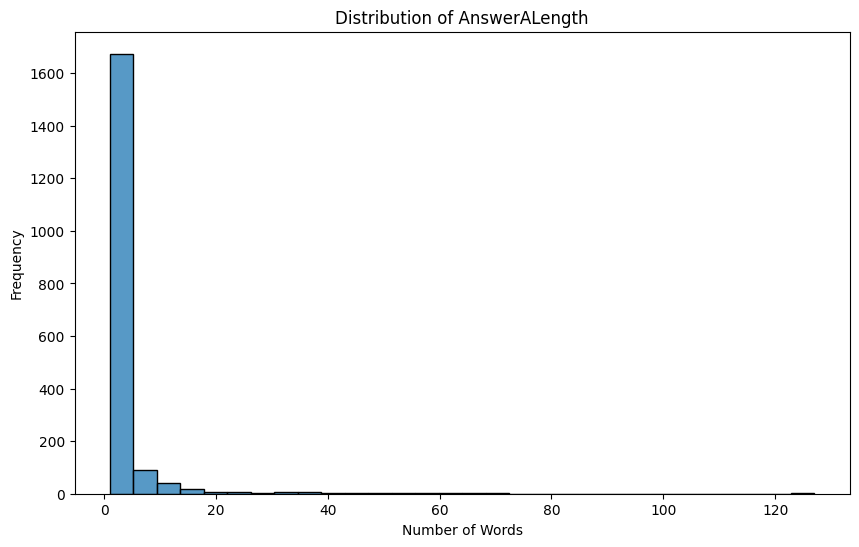

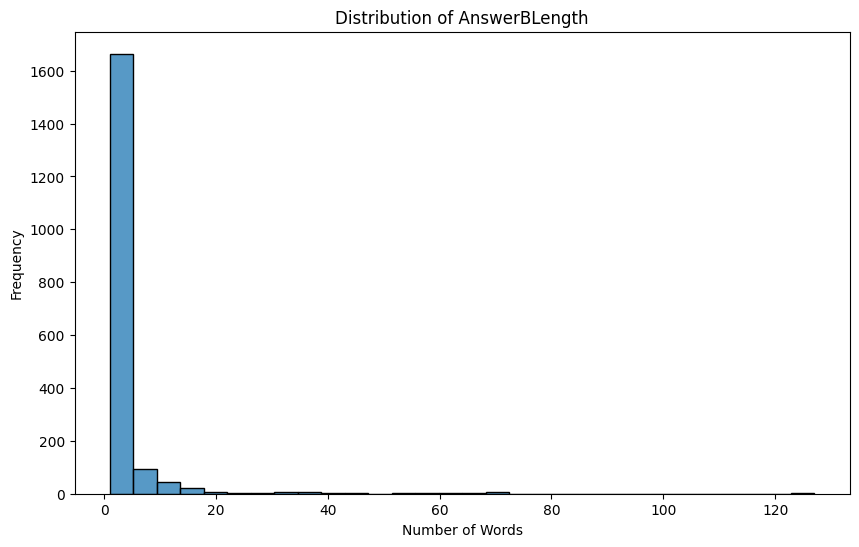

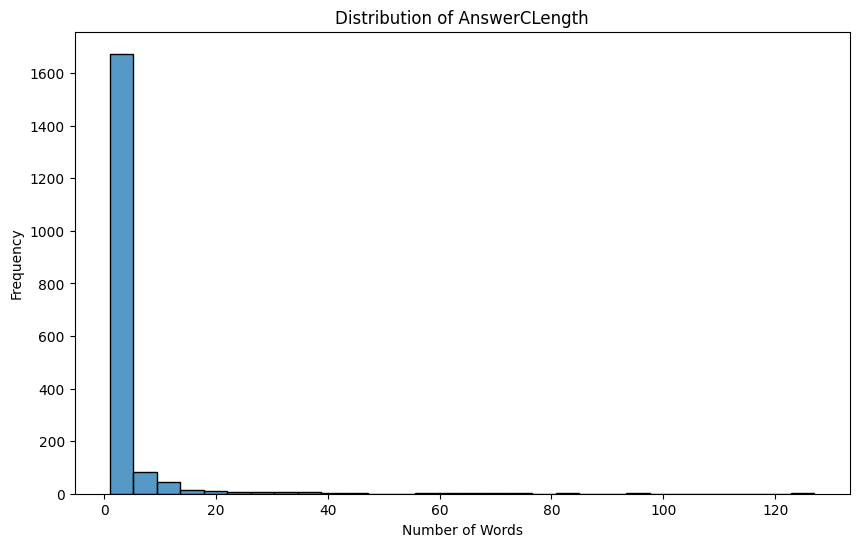

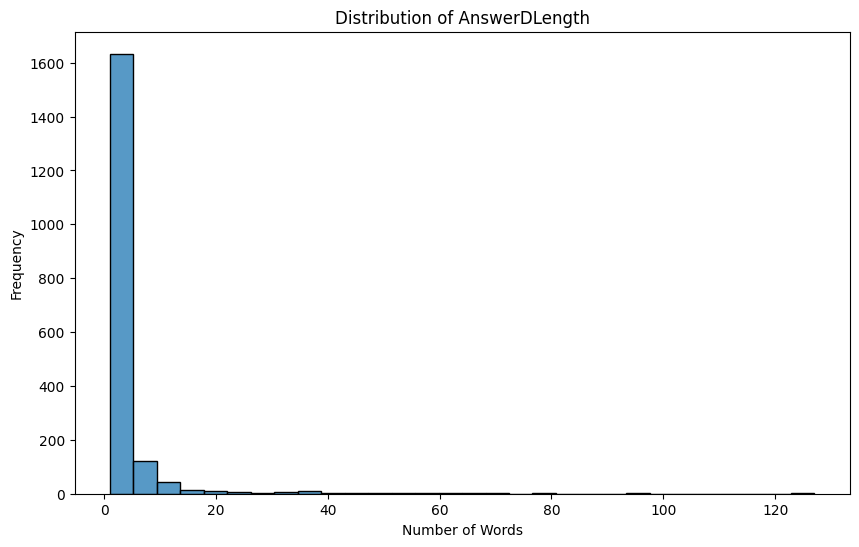

In [21]:
# Plot distribution of answer lengths
answer_lengths = ['AnswerALength', 'AnswerBLength', 'AnswerCLength', 'AnswerDLength']
for col in answer_lengths:
    plt.figure(figsize=(10,6))
    sns.histplot(data=train, x=col, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.show()


# Step 4: Data Preprocessing

4.1 Create a Dataset for Modeling
We need to transform the data into a suitable format for modeling.

4.1.1 Reshape Data

Each row should represent a single distractor (incorrect answer) along with its associated misconception.


In [22]:
# Initialize an empty list to store new rows
data_records = []

# Loop through each row in the train dataset
for index, row in train.iterrows():
    correct_answer = row['CorrectAnswer']
    question_text = row['QuestionText']
    for option in ['A', 'B', 'C', 'D']:
        # Only consider distractors
        if option != correct_answer:
            record = {
                'QuestionId': row['QuestionId'],
                'ConstructId': row['ConstructId'],
                'ConstructName': row['ConstructName'],
                'QuestionText': row['QuestionText'],
                'AnswerText': row[f'Answer{option}Text'],
                'MisconceptionId': row[f'Misconception{option}Id']
            }
            data_records.append(record)

# Create a new DataFrame
model_df = pd.DataFrame(data_records)

# Display the first few rows
print(model_df.head())


   QuestionId  ConstructId                                      ConstructName  \
0           0          856  Use the order of operations to carry out calcu...   
1           0          856  Use the order of operations to carry out calcu...   
2           0          856  Use the order of operations to carry out calcu...   
3           1         1612  Simplify an algebraic fraction by factorising ...   
4           1         1612  Simplify an algebraic fraction by factorising ...   

                                        QuestionText              AnswerText  \
0  \[\n3 \times 2+4-5\n\]\nWhere do the brackets ...  \( 3 \times 2+(4-5) \)   
1  \[\n3 \times 2+4-5\n\]\nWhere do the brackets ...   \( 3 \times(2+4-5) \)   
2  \[\n3 \times 2+4-5\n\]\nWhere do the brackets ...  Does not need brackets   
3  Simplify the following, if possible: \( \frac{...               \( m+1 \)   
4  Simplify the following, if possible: \( \frac{...               \( m+2 \)   

   MisconceptionId  
0          

4.2 Handle Missing Values in MisconceptionId

Ensure that all MisconceptionId values are integers.

In [23]:
# Convert MisconceptionId to integer
model_df['MisconceptionId'] = model_df['MisconceptionId'].astype(int)


4.3 Combine Question and Answer Texts

We will combine the question text with the answer text to create a single text input.

In [24]:
# Create a new column with combined text
model_df['CombinedText'] = model_df['QuestionText'] + ' ' + model_df['AnswerText']


4.4 Clean the Text Data

Define a function to clean the text.

In [25]:
import re

def clean_text(text):
    # Convert to string
    text = str(text)
    # Remove LaTeX expressions (e.g., \( ... \), \[ ... \])
    text = re.sub(r'\\[\(\[][^\\]*?\\[\)\]]', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the function to the CombinedText
model_df['CleanedText'] = model_df['CombinedText'].apply(clean_text)

# Display the cleaned text
print(model_df[['CombinedText', 'CleanedText']].head())


                                        CombinedText  \
0  \[\n3 \times 2+4-5\n\]\nWhere do the brackets ...   
1  \[\n3 \times 2+4-5\n\]\nWhere do the brackets ...   
2  \[\n3 \times 2+4-5\n\]\nWhere do the brackets ...   
3  Simplify the following, if possible: \( \frac{...   
4  Simplify the following, if possible: \( \frac{...   

                                         CleanedText  
0  times where do the brackets need to go to make...  
1  times where do the brackets need to go to make...  
2  times where do the brackets need to go to make...  
3        simplify the following if possible fracm mm  
4        simplify the following if possible fracm mm  


# Step 5: Feature Engineering

5.1 Convert Text to Numerical Features

We'll use TF-IDF vectorization.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the cleaned text
X = vectorizer.fit_transform(model_df['CleanedText'])

# Display the shape of the feature matrix
print(f"Feature matrix shape: {X.shape}")


Feature matrix shape: (5607, 2396)


5.2 Encode the Target Variable

Since MisconceptionId can be any integer, we'll use Label Encoding.

In [27]:
from sklearn.preprocessing import LabelEncoder

# Initialize the encoder
label_encoder = LabelEncoder()

# Fit and transform the MisconceptionId
y = label_encoder.fit_transform(model_df['MisconceptionId'])

# Number of unique misconceptions
num_classes = len(label_encoder.classes_)
print(f"Number of unique misconceptions: {num_classes}")


Number of unique misconceptions: 1605


# Step 6: Prepare the Data for Modeling

6.1 Split the Data

We'll split the data into training and validation sets.

In [29]:
import numpy as np

# Count the occurrences of each class label
(unique, counts) = np.unique(y, return_counts=True)
class_counts = np.asarray((unique, counts)).T

# Convert to DataFrame for better visualization
class_counts_df = pd.DataFrame(class_counts, columns=['ClassLabel', 'Count'])
print(class_counts_df.head())

# Find classes with only one sample
classes_with_one_sample = class_counts_df[class_counts_df['Count'] == 1]
print(f"Number of classes with only one sample: {len(classes_with_one_sample)}")

# Optionally, view these classes
print("Classes with only one sample:")
print(classes_with_one_sample)


   ClassLabel  Count
0           0   1237
1           1      1
2           2      2
3           3      2
4           4      1
Number of classes with only one sample: 747
Classes with only one sample:
      ClassLabel  Count
1              1      1
4              4      1
6              6      1
8              8      1
10            10      1
...          ...    ...
1588        1588      1
1593        1593      1
1596        1596      1
1597        1597      1
1601        1601      1

[747 rows x 2 columns]


In [30]:
# Get the list of class labels with only one sample
classes_to_remove = classes_with_one_sample['ClassLabel'].tolist()

# Create a boolean mask for samples not in these classes
mask = ~np.isin(y, classes_to_remove)

# Filter X and y
X_filtered = X[mask]
y_filtered = y[mask]

print(f"Original dataset size: {X.shape[0]}")
print(f"Filtered dataset size: {X_filtered.shape[0]}")


Original dataset size: 5607
Filtered dataset size: 4860


In [31]:
from sklearn.model_selection import train_test_split

# Split the data with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Training set size: 3888
Validation set size: 972


In [32]:
from sklearn.model_selection import train_test_split

# Split the data without stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Training set size: 4485
Validation set size: 1122


In [33]:
# Recalculate class counts
(unique_filtered, counts_filtered) = np.unique(y_filtered, return_counts=True)
class_counts_filtered = np.asarray((unique_filtered, counts_filtered)).T
class_counts_filtered_df = pd.DataFrame(class_counts_filtered, columns=['ClassLabel', 'Count'])

# Check for classes with less than two samples
classes_with_less_than_two = class_counts_filtered_df[class_counts_filtered_df['Count'] < 2]
print("Classes with less than two samples after filtering:")
print(classes_with_less_than_two)


Classes with less than two samples after filtering:
Empty DataFrame
Columns: [ClassLabel, Count]
Index: []


# Step 7: Model Building

Now, we'll build and train a baseline model to classify the misconceptions associated with each distractor. We'll start with a simple model and then work on improving it.

7.1 Train a Baseline Model
Let's start with the Multinomial Naive Bayes classifier, which is commonly used for text classification tasks.

Why Multinomial Naive Bayes?

It's fast and efficient for large datasets.
It performs well with sparse data like TF-IDF features.
Let's proceed step by step:

7.1.1 Import Necessary Libraries

In [35]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score


7.1.2 Initialize the Model

In [36]:
# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()


7.1.3 Train the Model

In [37]:
# Train the model on the training data
nb_classifier.fit(X_train, y_train)


MultinomialNB()

7.1.4 Evaluate the Model

In [38]:
# Predict on the validation set
y_pred = nb_classifier.predict(X_val)


7.1.5 Calculate Accuracy

In [39]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")


Validation Accuracy: 0.2317


7.1.6 Classification Report

In [40]:
# Generate a classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.23      1.00      0.38       260
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         5
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         1
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         2
          40       0.00      0.00      0.00         3
          41       0.00      0.00      0.00         1
    

# Step 8: Model Improvement

Now, let's try to improve the model's performance.

8.1 Try a Different Algorithm: Logistic Regression

Why Logistic Regression?

It's effective for multi-class classification problems.

It can handle imbalanced classes better with the right parameters.

8.1.1 Import the Model

In [41]:
from sklearn.linear_model import LogisticRegression


8.1.2 Initialize the Model

In [42]:
# Initialize Logistic Regression with maximum iterations set to 1000
logreg = LogisticRegression(max_iter=1000, n_jobs=-1)


8.1.3 Train the Model

In [43]:
# Train the model
logreg.fit(X_train, y_train)


LogisticRegression(max_iter=1000, n_jobs=-1)

8.1.4 Evaluate the Model

In [44]:
# Predict on the validation set
y_pred_logreg = logreg.predict(X_val)

# Calculate accuracy
accuracy_logreg = accuracy_score(y_val, y_pred_logreg)
print(f"Validation Accuracy: {accuracy_logreg:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_logreg))


Validation Accuracy: 0.2424
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.99      0.38       260
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         1
          22       0.00      0.00      0.00         5
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
          31       0.00      0.00      0.00         1
          36       0.00      0.00      0.00         1
          37       0.00      0.00      0.00         2
          40       0.00      0.00      0.00         3
          41       0.00      0

**8.2 Hyperparameter Tuning**

We can further improve the model by tuning hyperparameters.

8.2.1 Using Grid Search

In [45]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],  # Inverse of regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['lbfgs', 'saga']  # Solvers that support multi-class
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1,
    scoring='accuracy'
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000, n_jobs=-1),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'saga']},
             scoring='accuracy', verbose=1)

8.2.2 Best Parameters and Model

In [46]:
# Best parameters found
print("Best parameters found:")
print(grid_search.best_params_)

# Best estimator
best_logreg = grid_search.best_estimator_


Best parameters found:
{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


8.2.3 Evaluate the Tuned Model

In [47]:
# Predict on the validation set
y_pred_best = best_logreg.predict(X_val)

# Calculate accuracy
accuracy_best = accuracy_score(y_val, y_pred_best)
print(f"Tuned Logistic Regression Validation Accuracy: {accuracy_best:.4f}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_best))


Tuned Logistic Regression Validation Accuracy: 0.2469
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.53      0.36       260
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         1
          21       0.00      0.00      0.00         0
          22       1.00      0.80      0.89         5
          23       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         1
          29       0.00      0.00      0.00         1
    

8.3 Addressing Class Imbalance

Given that some classes might be underrepresented, you can try:

8.3.1 Adjust Class Weights

In [48]:
# Initialize Logistic Regression with class_weight='balanced'
logreg_balanced = LogisticRegression(max_iter=1000, n_jobs=-1, class_weight='balanced')

# Train the model
logreg_balanced.fit(X_train, y_train)

# Predict and evaluate
y_pred_balanced = logreg_balanced.predict(X_val)
accuracy_balanced = accuracy_score(y_val, y_pred_balanced)
print(f"Balanced Logistic Regression Validation Accuracy: {accuracy_balanced:.4f}")

# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred_balanced))


Balanced Logistic Regression Validation Accuracy: 0.1310
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       260
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         0
          20       0.00      0.00      0.00         1
          22       1.00      0.40      0.57         5
          23       0.00      0.00      0.00         1
 

# Step 9: Prepare the Test Data
Now, we'll prepare the test data in the same way we prepared the training data.

9.1 Transform Test Data into Modeling Format

9.1.1 Reshape the Test Data

In [50]:
# Initialize an empty list to store test records
test_records = []

# Loop through each row in the test dataset
for index, row in test.iterrows():
    correct_answer = row['CorrectAnswer']
    question_text = row['QuestionText']
    for option in ['A', 'B', 'C', 'D']:
        # Only consider distractors (incorrect answers)
        if option != correct_answer:
            record = {
                'QuestionId': row['QuestionId'],
                'QuestionId_Answer': f"{row['QuestionId']}_{option}",
                'QuestionText': row['QuestionText'],
                'AnswerText': row[f'Answer{option}Text'],
            }
            test_records.append(record)

# Create a DataFrame from the records
test_df = pd.DataFrame(test_records)

# Combine question and answer text
test_df['CombinedText'] = test_df['QuestionText'] + ' ' + test_df['AnswerText']


9.1.2 Clean the Text Data

Apply the same cleaning function you used on the training data.

In [51]:
# Use the clean_text function defined earlier
test_df['CleanedText'] = test_df['CombinedText'].apply(clean_text)


Ensure that you have the clean_text function defined in your code. If not, here's the function again:

In [52]:
def clean_text(text):
    # Convert to string
    text = str(text)
    # Remove LaTeX expressions
    text = re.sub(r'\\[\(\[][^\\]*?\\[\)\]]', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


9.2 Transform Text Data into Numerical Features

Use the same vectorizer that was fitted on the training data.

In [53]:
# Transform the test data using the fitted vectorizer
X_test = vectorizer.transform(test_df['CleanedText'])


# Step 10: Make Predictions on Test Data
10.1 Predict Misconceptions

Use your best model to predict the misconceptions.

In [54]:
# Use the best model to predict on test data
test_predictions = best_logreg.predict(X_test)


10.2 Convert Predictions Back to Original Misconception IDs

In [55]:
# Convert label indices back to original Misconception IDs
test_df['MisconceptionId'] = label_encoder.inverse_transform(test_predictions)


# Step 11: Prepare Submission File
11.1 Format the Predictions

According to the competition guidelines, you can predict up to 25 misconceptions per distractor, separated by spaces. Since our model predicts one misconception per distractor, we'll format it accordingly.

In [56]:
# Prepare the submission DataFrame
submission = test_df[['QuestionId_Answer', 'MisconceptionId']].copy()

# Convert MisconceptionId to string
submission['MisconceptionId'] = submission['MisconceptionId'].astype(str)


11.2 Predict Probabilities for Multiple Misconceptions (Optional)

10.3.1 Get Probabilities

In [57]:
# Get probability estimates
probabilities = best_logreg.predict_proba(X_test)


10.3.2 Get Top N Misconceptions

Let's select the top 3 misconceptions.

In [59]:
# Number of top misconceptions to select
top_n = 3

# Get indices of top N probabilities
top_n_indices = np.argsort(-probabilities, axis=1)[:, :top_n]

# Map indices back to Misconception IDs using list comprehension
top_n_misconceptions = [
    label_encoder.inverse_transform(indices) for indices in top_n_indices
]

# Convert the array of top misconceptions into space-separated strings
submission['MisconceptionId'] = [
    ' '.join(map(str, mis)) for mis in top_n_misconceptions
]


In [60]:
# Display the first few rows of the submission DataFrame
print(submission.head())


  QuestionId_Answer MisconceptionId
0            1869_B     -1 629 1514
1            1869_C     -1 629 1514
2            1869_D     -1 629 1514
3            1870_A     -1 1929 131
4            1870_B     -1 1929 131


In [61]:
# Display the first few rows of the submission
print(submission.head())


  QuestionId_Answer MisconceptionId
0            1869_B     -1 629 1514
1            1869_C     -1 629 1514
2            1869_D     -1 629 1514
3            1870_A     -1 1929 131
4            1870_B     -1 1929 131


In [62]:
# Save the submission file
submission.to_csv('submission.csv', index=False)
